<a href="https://colab.research.google.com/github/KamonohashiPerry/MachineLearning/blob/master/NGBoost_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reference
+ NGBoost Explained Comparison to LightGBM and XGBoost  
https://towardsdatascience.com/ngboost-explained-comparison-to-lightgbm-and-xgboost-fda510903e53

+ kyosek/NGBoost-experiments  
https://github.com/kyosek/NGBoost-experiments/tree/master/src/scripts

+ House Prices: Advanced Regression Techniques  
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data#_=_

## Install

In [0]:
pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

In [0]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [13]:
# drive mean root directory of  google drive
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/"Colab Notebooks"/NGBoost

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
NGBoost_Tutorial.ipynb	test.csv  train.csv


In [0]:
# import packages
from math import sqrt

import numpy as np
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import pandas as pd
import matplotlib.pyplot as plt

from ngboost.ngboost import NGBoost
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,mean_squared_error
from sklearn.model_selection import KFold

# for display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [0]:
# read the dataset
train = pd.read_csv('drive/Colab Notebooks/NGBoost/train.csv')
test = pd.read_csv('drive/Colab Notebooks/NGBoost/test.csv')

train = train.dropna(subset=['GarageCond','BsmtFinType2','MasVnrArea'])
test = test.dropna(subset=['GarageCond','BsmtFinType2','MasVnrArea'])

columns = ['MSSubClass','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',
            'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
            '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath',
            'BedroomAbvGr','KitchenAbvGr','Fireplaces','GarageYrBlt','GarageCars',
            'GarageArea','YrSold']

In [30]:
train, test = train.drop(['Id'],1), test.drop(['Id'],1)
train = train[train['GrLivArea']<4500]
train['SalePrice'] = np.log1p(train['SalePrice'])
y = train['SalePrice']

train_features = train.drop(['SalePrice'],1)
test_features = test

features = pd.concat([train_features, test_features]).reset_index(drop=True)

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

final_features = pd.get_dummies(features).reset_index(drop=True)

X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(y):, :]

outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
X = X.drop(overfit, axis=1)
X_sub = X_sub.drop(overfit, axis=1)

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)


alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

X['SalePrice'] = y
X = X.dropna()
X_tr, X_val = train_test_split(X,test_size=.2,random_state=42)

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [88]:
# NGBoost
ngb = NGBoost(Base=default_tree_learner, Dist=Normal, Score=MLE(), natural_gradient=True,verbose=False)
ngboost = ngb.fit(np.asarray(X_tr.drop(['SalePrice'],1)), np.asarray(X_tr.SalePrice))
y_pred = ngb.predict(X_val.drop(['SalePrice'],1))
sqrt(mean_squared_error(X_val.SalePrice,y_pred)) # 0.003389

0.395872621771948

In [95]:
# LightGBM
ltr = lgb.Dataset(X_tr.drop(['SalePrice'],1),label=X_tr.SalePrice)
param = {
        'bagging_freq': 5,
        'bagging_fraction': 0.6,
        'bagging_seed': 123,
        'boost_from_average':'false',
        'boost': 'gbdt',
        'feature_fraction': 0.3,
        'learning_rate': .01,
        'max_depth': 3,
        'metric':'rmse',
        'min_data_in_leaf': 128,
        'min_sum_hessian_in_leaf': 8,
        'num_leaves': 128,
        'num_threads': 8,
        'tree_learner': 'serial',
        'objective': 'regression',
        'verbosity': -1,
        'random_state':123,
        'max_bin': 8,
        'early_stopping_round':100
}
lgbm = lgb.train(param,ltr,num_boost_round=10000,valid_sets=[(ltr)],verbose_eval=1000)
y_pred = lgbm.predict(X_val.drop(['SalePrice'],1))
sqrt(mean_squared_error(X_val.SalePrice,y_pred)) # 0.00494

/content/LightGBM/python-package/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[1000]	training's rmse: 0.352956
[2000]	training's rmse: 0.345128
[3000]	training's rmse: 0.338816
[4000]	training's rmse: 0.333786
[5000]	training's rmse: 0.329087
[6000]	training's rmse: 0.325016
[7000]	training's rmse: 0.321329
[8000]	training's rmse: 0.317733
[9000]	training's rmse: 0.314489
[10000]	training's rmse: 0.311643
Did not meet early stopping. Best iteration is:
[10000]	training's rmse: 0.311643


0.41519343081427257

In [96]:
# XGBoost
params = {'max_depth': 4, 'eta': 0.01, 'objective':'reg:squarederror', 'eval_metric':['rmse'],'booster':'gbtree', 'verbosity':0,'sample_type':'weighted','max_delta_step':4, 'subsample':.5, 'min_child_weight':100,'early_stopping_round':50}
dtr, dte = xgb.DMatrix(X_tr.drop(['SalePrice'],1),label=X_tr.SalePrice), xgb.DMatrix(X_val.drop(['SalePrice'],1),label=X_val.SalePrice)
num_round = 5000
xgbst = xgb.train(params,dtr,num_round,verbose_eval=500)
y_pred = xgbst.predict(dte)
sqrt(mean_squared_error(X_val.SalePrice,y_pred)) # 0.00361

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.4191556992208141

## 各インスタンスごとの不確実性の伴ったプロット

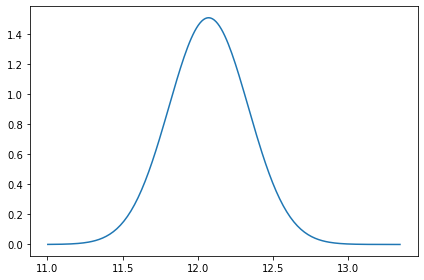

In [85]:
# see the probability distributions by visualising
Y_dists = ngb.pred_dist( X_val.drop(['SalePrice'],1).iloc[1:2,:] )
y_range = np.linspace(min(X_val.SalePrice), max(X_val.SalePrice), 200)
dist_values = Y_dists.pdf(y_range).transpose()

plt.plot(y_range,dist_values)
plt.tight_layout()
plt.show()

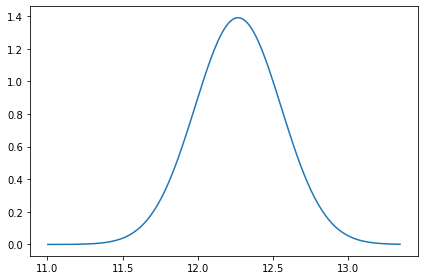

In [86]:
# see the probability distributions by visualising
Y_dists = ngb.pred_dist( X_val.drop(['SalePrice'],1).iloc[150:151,:] )
y_range = np.linspace(min(X_val.SalePrice), max(X_val.SalePrice), 200)
dist_values = Y_dists.pdf(y_range).transpose()

plt.plot(y_range,dist_values)
plt.tight_layout()
plt.show()